In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import os
import requests
from sklearn.linear_model import LinearRegression

# 定义代理服务器
proxies = {
    'http': 'http://192.168.123.200:20171',
    'https': 'http://192.168.123.200:20171'
}

# 配置 requests 使用代理
session = requests.Session()
session.proxies.update(proxies)

# 创建一个空的数据框来存储所有数据
all_data = pd.DataFrame()

# 定义股票代码
target_tickers = ["CLSK", "IREN", "WULF", "BTBT","COIN","CORZ","BITF","QQQ"]
base_tickers = ["IBIT", "MAGS"]
tickers = target_tickers + base_tickers
end_time = datetime.now()
start_time = end_time - timedelta(days=30*6)

# 下载数据
data = yf.download(tickers, start=start_time, end=end_time, session=session)['Adj Close']

all_data = data
# 计算每日收益率
returns = data.pct_change().dropna()

[*********************100%%**********************]  10 of 10 completed


In [4]:
from sklearn.linear_model import LinearRegression

# 创建一个空的数据框来存储回归结果
results_df = pd.DataFrame(columns=['Target', 'Intercept'] + base_tickers + ['R_squared', 'Noise Mean', 'Noise Std',"sum_p","mags_pct"])

# 对每个 target_tickers 进行多元回归计算
for target in target_tickers:
    X = returns[base_tickers]
    y = returns[target]

    # 创建并拟合回归模型
    model = LinearRegression().fit(X, y)

    # 获取回归系数和截距
    weights = model.coef_
    intercept = model.intercept_
    r_squared = model.score(X, y)

    # 计算回归残差（噪声）
    predicted_y = model.predict(X)
    noise = y - predicted_y

    # 将结果添加到数据框中
    [base_1,base_2] = list(weights)
    results = [target, intercept] + [base_1,base_2] + [r_squared, noise.mean(), noise.std(),sum([base_1,base_2])*r_squared,base_1-base_2]
    results_df.loc[len(results_df)] = results

# 如果需要在 Jupyter Notebook 中显示数据框
from IPython.display import display
display(results_df)

,Target,Intercept,IBIT,MAGS,R_squared,Noise Mean,Noise Std,sum_p,mags_pct
0,CLSK,0.003426,1.126208,0.745223,0.304741,-9.175397e-19,0.065388,0.570302,0.380985
1,IREN,0.004313,0.690547,1.375789,0.195633,2.408542e-18,0.070550,0.404244,-0.685242
2,WULF,0.008457,0.784140,0.780469,0.162608,1.605694e-18,0.072639,0.254418,0.003671
3,BTBT,-0.000182,0.858738,0.819746,0.234000,2.293849e-19,0.062930,0.392765,0.038992
4,COIN,0.000598,1.004219,0.647377,0.566363,-4.587698e-19,0.033682,0.935404,0.356842
5,CORZ,0.006125,0.658092,0.817957,0.179457,2.064464e-18,0.060360,0.264887,-0.159865
6,BITF,0.000361,0.634249,0.303278,0.164915,-2.293849e-19,0.053320,0.154612,0.330970
7,QQQ,-0.000437,0.024225,0.578558,0.827993,3.584139e-19,0.004102,0.499100,-0.554332


In [5]:
results_dict = results_df.to_dict(orient='records')
results_dict

[{'Target': 'CLSK',
  'Intercept': 0.003425765971350329,
  'IBIT': 1.126208297613911,
  'MAGS': 0.7452231659304627,
  'R_squared': 0.3047408692022079,
  'Noise Mean': -9.175396897728567e-19,
  'Noise Std': 0.0653875839576945,
  'sum_p': 0.5703016508528724,
  'mags_pct': 0.3809851316834483},
 {'Target': 'IREN',
  'Intercept': 0.004312915309348075,
  'IBIT': 0.690547277583348,
  'MAGS': 1.3757890036873344,
  'R_squared': 0.19563342323179989,
  'Noise Mean': 2.4085416856537488e-18,
  'Noise Std': 0.07055045136617567,
  'sum_p': 0.4042444402530509,
  'mags_pct': -0.6852417261039864},
 {'Target': 'WULF',
  'Intercept': 0.008457026034922497,
  'IBIT': 0.7841399876475283,
  'MAGS': 0.7804687305596243,
  'R_squared': 0.1626079848826112,
  'Noise Mean': 1.6056944571024992e-18,
  'Noise Std': 0.07263852223120427,
  'sum_p': 0.25441787079743033,
  'mags_pct': 0.0036712570879040562},
 {'Target': 'BTBT',
  'Intercept': -0.00018205893405886728,
  'IBIT': 0.8587382311465378,
  'MAGS': 0.8197457327631

In [113]:
(results_df.values[4,2]-results_df.values[4,3])/results_df.values[4,2]

IndexError: index 4 is out of bounds for axis 0 with size 0

[*********************100%%**********************]  9 of 9 completed
/root/miniconda3/envs/nnquant/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/nnquant/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/nnquant/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/nnquant/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/nnquant/lib/python3.10/site-packages/

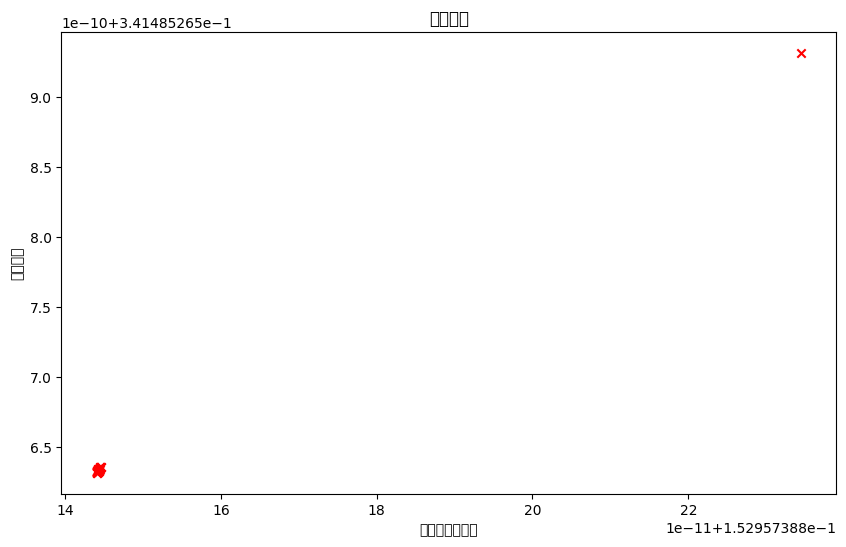

In [95]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 定义股票代码和时间范围
tickers = ["CLSK", "IREN", "WULF", "BTBT", "COIN", "CORZ", "BITF", "QQQ", "MAGS"]
end_time = datetime.now()
start_time = end_time - timedelta(days=365)  # 1年的数据

# 下载数据
data = yf.download(tickers, start=start_time, end=end_time)['Adj Close']

# 计算每日收益率
returns = data.pct_change().dropna()

# 计算平均收益率和协方差矩阵
mean_returns = returns.mean()
cov_matrix = returns.cov()

# 定义组合的期望收益和风险
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return returns, std

# 定义优化目标函数
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    p_returns, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    return - (p_returns - risk_free_rate) / p_std

# 约束条件和边界
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(tickers)))

# 初始权重
initial_weights = len(tickers) * [1. / len(tickers)]

# 优化组合
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix),
                             method='SLSQP', bounds=bounds, constraints=constraints)

# 获取有效前沿上的组合
def calculate_efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficient_portfolios = []
    for target_return in returns_range:
        constraints = (
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'eq', 'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix)[0] - target_return}
        )
        result = minimize(portfolio_volatility, initial_weights, args=(mean_returns, cov_matrix),
                          method='SLSQP', bounds=bounds, constraints=constraints)
        efficient_portfolios.append(result)
    return efficient_portfolios

# 计算组合的风险
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

# 定义预期收益率范围
returns_range = np.linspace(mean_returns.min(), mean_returns.max(), 50)

# 计算有效前沿
efficient_portfolios = calculate_efficient_frontier(mean_returns, cov_matrix, returns_range)

# 提取有效前沿的风险和收益
frontier_returns = [portfolio_performance(p.x, mean_returns, cov_matrix)[0] for p in efficient_portfolios]
frontier_volatilities = [portfolio_performance(p.x, mean_returns, cov_matrix)[1] for p in efficient_portfolios]

# 绘制有效前沿
plt.figure(figsize=(10, 6))
plt.scatter(frontier_volatilities, frontier_returns, c='r', marker='x')
plt.xlabel('风险（标准差）')
plt.ylabel('预期收益')
plt.title('有效前沿')
plt.show()


In [26]:
from scipy import stats

# Calculate daily returns
returns = all_data.pct_change().dropna()

# Define a function to calculate beta
def calculate_beta(stock_returns, market_returns):
    beta, alpha, r_value, p_value, std_err = stats.linregress(market_returns, stock_returns)
    return [beta, alpha, r_value, p_value, std_err]

# Calculate beta for each stock against QQQ and IBIT
beta_results = {}
for stock in ["CLSK", "IREN", "WULF", "BTBT"]:
    beta_qqq = calculate_beta(returns[stock], returns["QQQ"])
    beta_eth = calculate_beta(returns[stock], returns["ETH-USD"])
    beta_btc = calculate_beta(returns[stock], returns["BTC-USD"])
    beta_results[stock] = {"Beta vs QQQ": (beta_qqq[0],beta_qqq[3]), "Beta vs BTC-USD":( beta_btc[0],beta_btc[3]),"Beta vs ETH-USD":( beta_eth[0],beta_eth[3]) }

# Display the beta coefficients
beta_df = pd.DataFrame(beta_results).T

print(beta_df)

                                      Beta vs QQQ  \
CLSK   (2.604997611672954, 0.0006886068854324499)   
IREN   (5.262714735433806, 8.449263098329666e-06)   
WULF  (3.7638778936793744, 0.0031066431507313632)   
BTBT   (3.6423141680265556, 0.009563338802749403)   

                                   Beta vs BTC-USD  \
CLSK   (0.6998099834032947, 0.0024902068315644284)   
IREN     (0.11789098441504334, 0.7584640328603584)   
WULF     (0.4637148350837259, 0.23690603545775835)   
BTBT  (1.4776134036326072, 0.00029644379090698326)   

                                  Beta vs ETH-USD  
CLSK   (0.4259281474309018, 0.004205779174626516)  
IREN   (0.012432245678961746, 0.9596397267036112)  
WULF  (-0.012440522564827649, 0.9607288650586014)  
BTBT   (0.7084638234167662, 0.008308003523288266)  


/tmp/ipykernel_3175307/2559864271.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = all_data.pct_change().dropna()


In [27]:
beta_df

,Beta vs QQQ,Beta vs BTC-USD,Beta vs ETH-USD
CLSK,"(2.604997611672954, 0.0006886068854324499)","(0.6998099834032947, 0.0024902068315644284)","(0.4259281474309018, 0.004205779174626516)"
IREN,"(5.262714735433806, 8.449263098329666e-06)","(0.11789098441504334, 0.7584640328603584)","(0.012432245678961746, 0.9596397267036112)"
WULF,"(3.7638778936793744, 0.0031066431507313632)","(0.4637148350837259, 0.23690603545775835)","(-0.012440522564827649, 0.9607288650586014)"
BTBT,"(3.6423141680265556, 0.009563338802749403)","(1.4776134036326072, 0.00029644379090698326)","(0.7084638234167662, 0.008308003523288266)"


In [28]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# 定义股票代码
tickers = ["CLSK", "QQQ", "BTC-USD"]
end_time = datetime.now()
start_time = end_time - timedelta(days=365)  # 1年的数据

# 下载数据
data = yf.download(tickers, start=start_time, end=end_time)['Adj Close']

# 计算每日收益率
returns = data.pct_change().dropna()

# 准备回归模型输入
X = returns[['QQQ', 'BTC-USD']]
y = returns['CLSK']

# 创建并拟合回归模型
model = LinearRegression().fit(X, y)

# 获取回归系数
weights = model.coef_
intercept = model.intercept_

# 计算回归残差（噪声）
predicted_y = model.predict(X)
noise = y - predicted_y

# 打印结果
print(f"CLSK 对 QQQ 的权重: {weights[0]}")
print(f"CLSK 对 BTC 的权重: {weights[1]}")
print(f"模型截距: {intercept}")
print(f"噪声部分均值: {noise.mean()}")

# 显示回归结果
results = pd.DataFrame({
    'Actual': y,
    'Predicted': predicted_y,
    'Noise': noise
})

# 在 Jupyter Notebook 中显示结果数据框
from IPython.display import display
display(results.head())


[*********************100%%**********************]  3 of 3 completed

CLSK 对 QQQ 的权重: 1.7276086663238348
CLSK 对 BTC 的权重: 0.9866942489593576
模型截距: 0.0004118588172618218
噪声部分均值: -2.287547440848537e-19



/tmp/ipykernel_3175307/3104269411.py:15: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


,Actual,Predicted,Noise
Date,,,
2023-07-18,-0.045388,0.005075,-0.050463
2023-07-19,0.069018,0.001905,0.067114
2023-07-20,-0.067432,-0.043434,-0.023998
2023-07-21,-0.012308,-0.000904,-0.011404
2023-07-22,0.000000,-0.004106,0.004106
